# Данные

Сайт **http://www.selpravda.ru/** - газета Мокшанского района Пензенской области (полностью селский район, центр района - поселок). Более 7к текстов с датой, заголовками и разделом, к которому была отнесена статья

In [0]:
# drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# unzipping
import zipfile

path = "/content/drive/My Drive/gazeta.zip"

zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall("unzipped_files")
zip_ref.close()

In [0]:
import os

DIR = "/content/unzipped_files/gazeta"

files = os.listdir(DIR)

In [0]:
import re
texts = []
topics = []
for filename in files:
    with open(os.path.join(DIR, filename), "r", encoding='utf-8') as f:
        text = f.read()
        m = re.search('(.+?)topic (.+?)\n(.+)', text)
        if m:
            texts.append(m.group(3).strip())
            topics.append(m.group(2).strip())
        else:
            print(text)

@au Noname
@ti Социальная направленность
@da 09.03.2011
@topic Политика

@au Noname
@ti Дела и проблемы сельской администрации
@da 21.11.2012
@topic Власть и общество

@au Noname
@ti Внимание! Пропал ребенок!
@da 22.09.2016
@topic Власть и общество



In [0]:
import pandas as pd

df = pd.DataFrame({'text': texts, 'source': topics})

In [0]:
df.head()

,text,source
0,"С сентября в нашем детском саду ""Солнышко"" ста...",Образование
1,Выполняя Указ Президента Российской Федерации ...,Политика
2,Общий объем финансирования составит - 816 ты...,Социальная сфера
3,"При анализе уголовных, дел возбужденных в ОМВД...",Происшествия и Безопасность
4,"На вопрос, почему стихийные свалки возникают с...",Благоустройство и ЖКХ


In [0]:
df['source'].value_counts()

Социальная сфера               1650
Общество                       1063
Спорт                          1013
Образование                     717
Власть и общество               678
Сельское хозяйство района       462
Благоустройство и ЖКХ           428
Политика                        333
Происшествия и Безопасность     247
Регион-центр                    177
Здравоохранение                 115
Культура                         58
Экономика                        56
Человек и Закон                  13
Предпринимательство               3
Люди села                         2
Музей Журналистики                2
Name: source, dtype: int64

In [0]:
# merge-им "власть и общество" и "политику"
# texts = []
# topics = []
# for filename in files:
#     with open(os.path.join(DIR, filename), "r", encoding='utf-8') as f:
#         text = f.read()
#         m = re.search('(.+?)topic (.+?)\n(.+)', text)
#         if m:
#             if m.group(2).strip() == 'Власть и общество':
#                 topics.append('Политика')
#             else:
#                 topics.append(m.group(2).strip())
#             texts.append(m.group(3).strip())

# df = pd.DataFrame({'text': texts, 'source': topics})

# можно было сделать это же следующим образом:
df.source.replace(['Власть и общество'], ['Политика'], inplace=True)

In [0]:
df['source'].value_counts()

Социальная сфера               1650
Общество                       1063
Спорт                          1013
Политика                       1011
Образование                     717
Сельское хозяйство района       462
Благоустройство и ЖКХ           428
Происшествия и Безопасность     247
Регион-центр                    177
Здравоохранение                 115
Культура                         58
Экономика                        56
Человек и Закон                  13
Предпринимательство               3
Музей Журналистики                2
Люди села                         2
Name: source, dtype: int64

Возьмём первые четыре темы и из каждой темы возьмём по 1000 примеров случаным образом, чтобы получить равномерную выборку.

In [0]:
soc_sphere = df[df['source'] == 'Социальная сфера'].sample(n=1000)
society_sphere = df[df['source'] == 'Общество'].sample(n=1000)
sport_sphere = df[df['source'] == 'Спорт'].sample(n=1000)
politics_sphere = df[df['source'] == 'Политика'].sample(n=1000)

In [0]:
# Конкатенируем полученные датафреймы в один датафрейм
df = pd.concat([soc_sphere, society_sphere, sport_sphere, politics_sphere])

In [0]:
df.head()

,text,source
4459,Человек - сам кузнец своего счастья - глас...,Социальная сфера
961,Летние каникулы для школьников самое прекрасно...,Социальная сфера
4568,"Филиал ПАО ""МРСК Волги"" - ""Пензаэнерго"" предуп...",Социальная сфера
5841,Наш детский сад всегда принимает участие в раз...,Социальная сфера
6940,5 мая глава администрации района Николай Тихом...,Социальная сфера


In [0]:
df.tail()

,text,source
1562,В Мокшанском районе за 5 месяцев 2013 года вве...,Политика
2210,Депутат Законодательного Собрания Пензенской о...,Политика
3648,Вел прием начальник Управления по работе с обр...,Политика
205,Уважаемые граждане! 9 августа 2012 года по все...,Политика
4061,"Согласно мониторингу, цена на социально значим...",Политика


# Задача

Будем решать задачу тематической классификации. Формально задача заключается в следующем: по тексту ($d$) определить, какой он тематики, то есть, к какому классу $c$ ("Социальная сфера" / "Общество" / "Спорт" / "Политика") он принадлежит. 

## Описательные статистики
TODO:
* лемматизируем текст и удалим пунктуацию и стоп-слова из текстов (с помощью nltk)
* посчитаем количество слов (без лемматизации и с лемматизацией) в коллекции
* найдём среднюю длину текста в словах и символах
* найдём 10 самых частых существительных в текстах каждого паблика 

In [0]:
# удалим nan-значения, если таковые в датафрейме есть
df = df.dropna(how='any')
# сбросим индекс (после конкатенация строки занумерованы не по порядку)
df = df.reset_index(drop=True)

In [0]:
df.shape

(4000, 2)

In [0]:
# количество текстов
print("Количество текстов:", df.shape[0])

Количество текстов: 4000


In [0]:
# количество классов
print("Количество классов:", len(pd.unique(df[:]["source"])))

Количество классов: 4


In [0]:
# подключаем необходимые библиотеки

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
!pip install pymorphy2[fast]
import pymorphy2
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()
from string import punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
noise = stopwords.words('russian') + list(punctuation)

In [0]:
# приводим к нижнему регистру и удаляем стоп-слова и знаки пунктуации
df['lowered_words'] = df['text'].apply(lambda text: [word.strip(punctuation) for word in word_tokenize(text.lower()) if word not in noise and word.strip(punctuation)])

In [0]:
# сохраняем всю грамматическую информацию о словах в каждом тексте (берём самый вероятный вариант из предлагаемых pymorphy)
df['Parse'] = df['lowered_words'].apply(lambda words: [pymorphy2_analyzer.parse(word)[0] for word in words])

In [0]:
# берём лемму у каждого слова и получаем массив слов для каждого документа
df['lemmatized_words'] = df['Parse'].apply(lambda parse_words: [word.normal_form if word.normal_form else word.word for word in parse_words])

In [0]:
words = set()
for i in range(df.shape[0]):
    words.update(set(df.iloc[i]["lowered_words"]))

In [0]:
# количество слов без лемматизации в коллекции
print("Количество слов без лемматизации:", len(words))

Количество слов без лемматизации: 82468


In [0]:
lemmatized_words = set()
for i in range(df.shape[0]):
    lemmatized_words.update(set(df.iloc[i]["lemmatized_words"]))

In [0]:
# количество слов с лемматизацией в коллекции
print("Количество слов с лемматизацией:", len(lemmatized_words))

Количество слов с лемматизацией: 38185


Т.е. больше в среднем в корпусе по две (даже чуть больше) словоформы на каждую лексему.

In [0]:
df['symbols_length'] = df['text'].apply(lambda x: len(x))
df['words_length'] = df['lowered_words'].apply(lambda x: len(x))

In [0]:
# средние длины текстов в словах и символах
print("Средняя длина текста в символах:", df['symbols_length'].mean())

Средняя длина текста в символах: 1956.8345


In [0]:
print("Средняя длина текста в словах:", df['words_length'].mean())

Средняя длина текста в словах: 195.948


In [0]:
# сохраним также части речи слов документа в отдельном столбце
df['POS'] = df['Parse'].apply(lambda parse_words: [parse_word.tag.POS for parse_word in parse_words])

In [0]:
df.head()

,text,source,lowered_words,Parse,lemmatized_words,symbols_length,words_length,POS
0,Человек - сам кузнец своего счастья - глас...,Социальная сфера,"[человек, кузнец, своего, счастья, гласит, нар...","[(человек, NOUN,anim,masc sing,nomn, человек, ...","[человек, кузнец, свой, счастие, гласить, наро...",2395,230,"[NOUN, NOUN, ADJF, NOUN, VERB, ADJF, NOUN, ADV..."
1,Летние каникулы для школьников самое прекрасно...,Социальная сфера,"[летние, каникулы, школьников, самое, прекрасн...","[(летние, ADJF plur,nomn, летний, 0.5, ((<Dict...","[летний, каникулы, школьник, самый, прекрасный...",463,45,"[ADJF, NOUN, NOUN, ADJF, ADJF, NOUN, NOUN, NPR..."
2,"Филиал ПАО ""МРСК Волги"" - ""Пензаэнерго"" предуп...",Социальная сфера,"[филиал, пао, мрск, волги, пензаэнерго, предуп...","[(филиал, NOUN,inan,masc sing,accs, филиал, 0....","[филиал, пао, мрск, волга, пензаэнерго, предуп...",2113,204,"[NOUN, None, NOUN, NOUN, NOUN, VERB, NOUN, NOU..."
3,Наш детский сад всегда принимает участие в раз...,Социальная сфера,"[наш, детский, сад, принимает, участие, различ...","[(наш, ADJF,Apro masc,sing,nomn, наш, 0.6, ((<...","[наш, детский, сад, принимать, участие, различ...",3210,332,"[ADJF, ADJF, NOUN, VERB, NOUN, ADJF, NOUN, ADV..."
4,5 мая глава администрации района Николай Тихом...,Социальная сфера,"[5, мая, глава, администрации, района, николай...","[(5, NUMB,intg, 5, 1.0, ((<NumberAnalyzer>, '5...","[5, май, глава, администрация, район, николай,...",715,79,"[None, NOUN, NOUN, NOUN, NOUN, NOUN, NOUN, VER..."


In [0]:
# найдём 10 самых частых существительных в текстах каждого паблика
from collections import Counter

dct = dict()
for public in pd.unique(df[:]["source"]):
    words = []
    for text, poses in zip(df[df['source'] == public]['lemmatized_words'], df[df['source'] == public]['POS']):
        words.extend([word for i, word in enumerate(text) if poses[i] == 'NOUN'])
    print('topic:', public)
    print(*Counter(words).most_common(10))
    dct[public] = {pair[0] for pair in Counter(words).most_common(10)}

topic: Социальная сфера
('год', 2084) ('ребёнок', 1430) ('район', 1144) ('человек', 1091) ('работа', 840) ('семья', 811) ('дом', 626) ('жизнь', 624) ('день', 604) ('время', 566)
topic: Общество
('год', 2316) ('район', 1691) ('человек', 1079) ('ребёнок', 1030) ('гражданин', 1003) ('средство', 903) ('работа', 718) ('рф', 715) ('время', 710) ('движение', 710)
topic: Спорт
('команда', 1776) ('год', 1723) ('место', 1535) ('соревнование', 1386) ('район', 1375) ('школа', 930) ('спорт', 811) ('область', 804) ('участие', 697) ('ребёнок', 668)
topic: Политика
('год', 2406) ('район', 2103) ('область', 1902) ('вопрос', 1513) ('работа', 1409) ('рубль', 1165) ('администрация', 1101) ('глава', 958) ('человек', 915) ('развитие', 887)


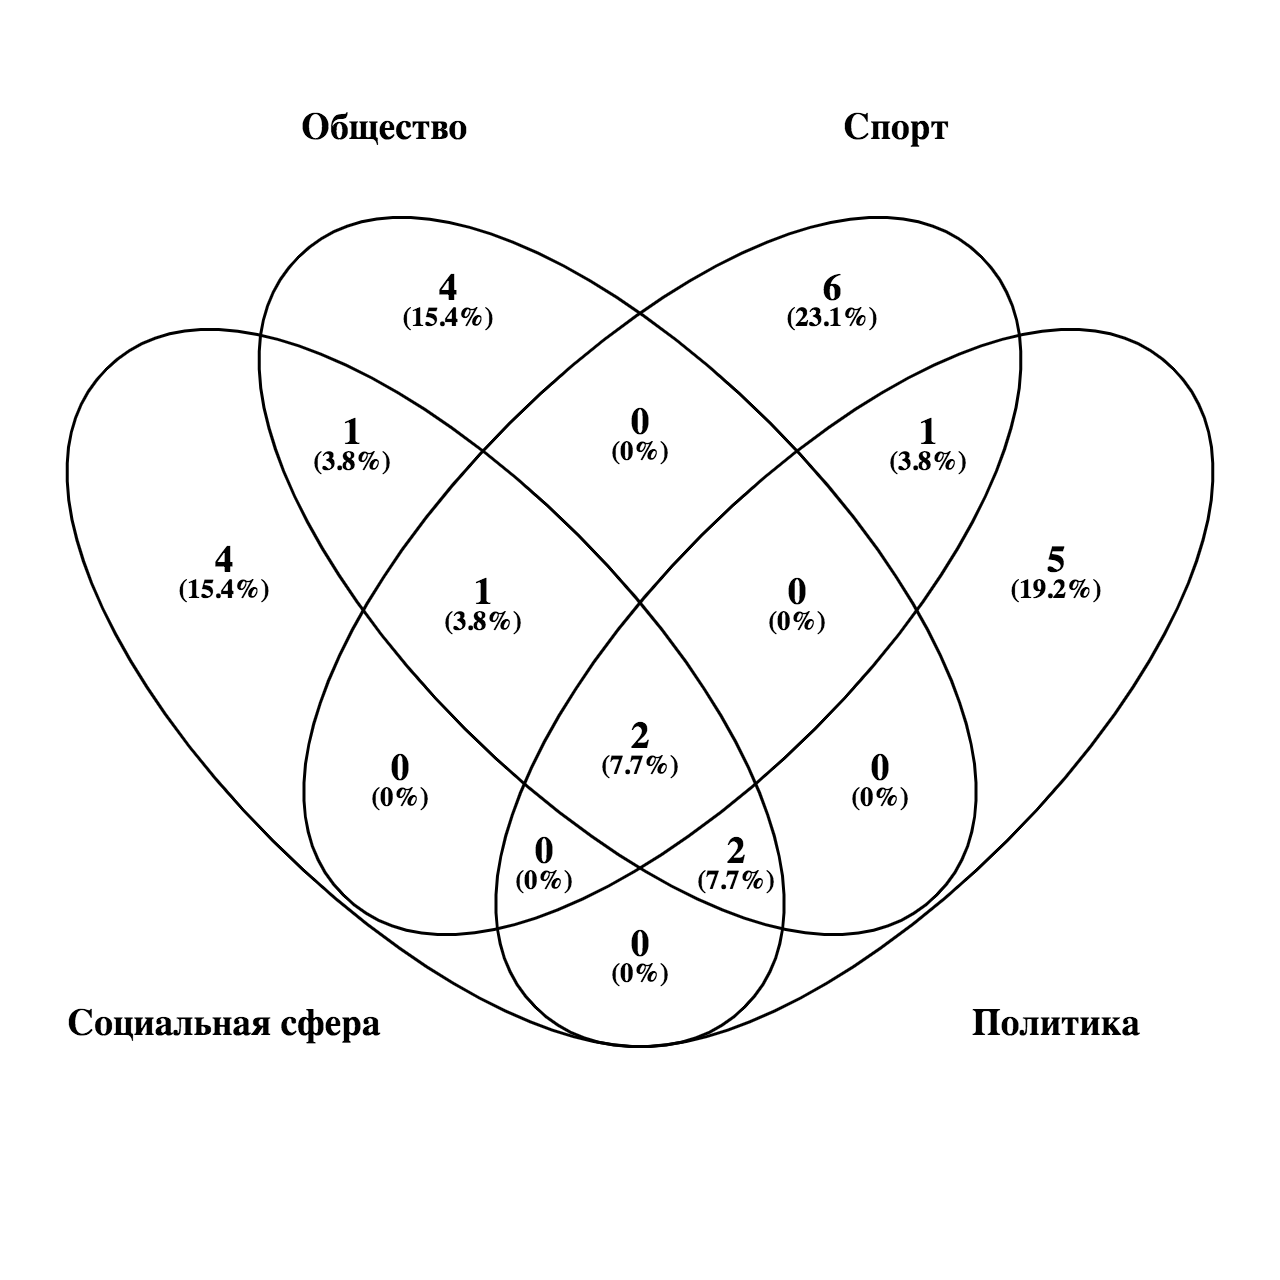

In [0]:
from IPython.display import Image
Image('/content/drive/My Drive/vienn_diagram.png', width=600, height=600)

In [0]:
# общие слова для всех топиков
common = dct['Социальная сфера'] & dct['Общество'] & dct['Спорт'] & dct['Политика']
print(common)

{'год', 'район'}


In [0]:
# общие слова для социальной сферы, общества и спорта
dct['Социальная сфера'] & dct['Общество'] & dct['Спорт'] - common

{'ребёнок'}

In [0]:
# общие слова для социальной сферы, общества и политики
dct['Социальная сфера'] & dct['Общество'] & dct['Политика'] - common

{'работа', 'человек'}

In [0]:
# общие слова для социальной сферы, политики и спорта
dct['Социальная сфера'] & dct['Политика'] & dct['Спорт'] - common

set()

In [0]:
# общие слова для общества, политики и спорта
dct['Общество'] & dct['Политика'] & dct['Спорт'] - common

set()

In [0]:
print(dct['Политика'] & dct['Спорт'] - common,
      dct['Политика'] & dct['Общество'] - common,
      dct['Политика'] & dct['Социальная сфера'] - common,
      dct['Спорт'] & dct['Общество'] - common,
      dct['Спорт'] & dct['Социальная сфера'] - common,
      dct['Социальная сфера'] & dct['Общество'] - common,
      sep = '\n')

{'область'}
{'работа', 'человек'}
{'работа', 'человек'}
{'ребёнок'}
{'ребёнок'}
{'время', 'работа', 'человек', 'ребёнок'}


In [0]:
# if we want to delete some columns
# df = df.drop(['symbols_length', 'words_length', 'lowered_words', 'Parse', 'lemmatized_words', 'POS'], axis=1)

Добавим также лемматизированный текст (т.е. с-join-им поле lemmatized_words).

In [0]:
df['lemmatized_text'] = df['lemmatized_words'].apply(lambda x: ' '.join(x))

Разделите коллекцию текстов на обучающую и тестовую части в соотношение 80% на 20%. 

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train_full, X_test_full, y_train, y_test = train_test_split(df.loc[:, df.columns != 'source'], df['source'], test_size=0.2, random_state=21)

In [0]:
X_train_full.shape, X_test_full.shape, y_train.shape, y_test.shape

((3200, 8), (800, 8), (3200,), (800,))

In [0]:
# темы распределены равномерно
print(y_train.value_counts())

Политика            811
Спорт               803
Общество            797
Социальная сфера    789
Name: source, dtype: int64


## Классификация по правилам

Оценим с помощью классификации по правилам минимальный baseline, который должны превосходить более сложные модели (например, нейросети)
 
 * Разработаем несколько правил вида "Если встречается слово $w$, то текст имеет тему $c$". Для этого определим, какие слова среди топ-10 уникальны для темы.
 * Посчитаем метрики для классификации по правилам (точность, полноту, $f$-меру и $accuracy$)
 * Убедимся в том, что наши правила ошибаются.

In [0]:
dct['Социальная сфера'] - (dct['Политика'] | dct['Спорт'] | dct['Общество'])

{'день', 'дом', 'жизнь', 'семья'}

In [0]:
dct['Политика'] - (dct['Социальная сфера'] | dct['Спорт'] | dct['Общество'])

{'администрация', 'вопрос', 'глава', 'развитие', 'рубль'}

In [0]:
dct['Спорт'] - (dct['Социальная сфера'] | dct['Политика'] | dct['Общество'])

{'команда', 'место', 'соревнование', 'спорт', 'участие', 'школа'}

In [0]:
dct['Общество'] - (dct['Социальная сфера'] | dct['Политика'] | dct['Спорт'])

{'гражданин', 'движение', 'рф', 'средство'}

In [0]:
import random

# задаём правила
def rules(text):
    if text & {'дом', 'семья', 'жизнь', 'день'}:
        return 'Социальная сфера'
    elif text & {'администрация', 'глава', 'развитие', 'вопрос', 'рубль'}:
        return 'Политика'
    elif text & {'команда', 'соревнование', 'спорт', 'школа', 'участие', 'место'}:
        return 'Спорт'
    elif text & {'гражданин', 'рф', 'движение', 'средство'}:
        return 'Общество'
    else: # случайный выбор
        return random.choice(['Социальная сфера', 'Политика', 'Спорт', 'Общество'])

In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels=['Социальная сфера', 'Политика', 'Спорт', 'Общество']

# определяем функции для визуализации работы алгоритма и подсчёта метрик
def get_cm(X, y):
    predictions = []
    for index, row in X.iterrows():
        predictions.append(rules(set(row['lowered_words'])))
    cm = confusion_matrix(y, predictions, labels)
    return cm

def plot_cm(cm):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True);

def print_metrics_from_cm(cm):
    precisions = np.diag(cm) / np.sum(cm, axis=0)
    recalls = np.diag(cm) / np.sum(cm, axis=1)
    mean_precision = np.mean(precisions)
    print("Mean Precision:", mean_precision)
    mean_recall = np.mean(recalls)
    print("Mean Recall", mean_recall)
    print("Accuracy:", np.sum(np.diag(cm)) / np.sum(cm))
    print("F1 score:", 2 * mean_precision * mean_recall / (mean_precision + mean_recall))

Mean Precision: 0.4585435972455117
Mean Recall 0.43884800753496445
Accuracy: 0.43875
F1 score: 0.4484796669528327


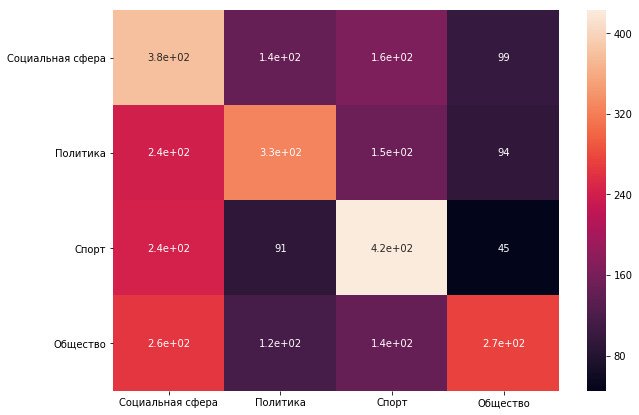

In [0]:
# На обучающей выборке

cm = get_cm(X_train_full, y_train)
plot_cm(cm)
print_metrics_from_cm(cm)

Mean Precision: 0.43862308354739094
Mean Recall 0.42630428909871404
Accuracy: 0.4275
F1 score: 0.4323759606356318


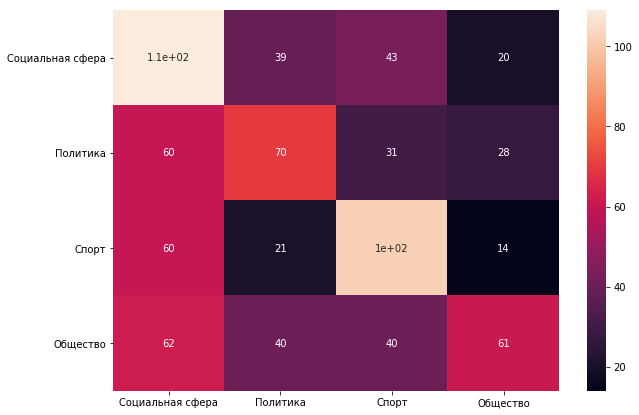

In [0]:
# На тестовой выборке

cm = get_cm(X_test_full, y_test)
plot_cm(cm)
print_metrics_from_cm(cm)

Mean Precision: 0.45052107061353464
Mean Recall 0.43475
Accuracy: 0.43475
F1 score: 0.442495054793762


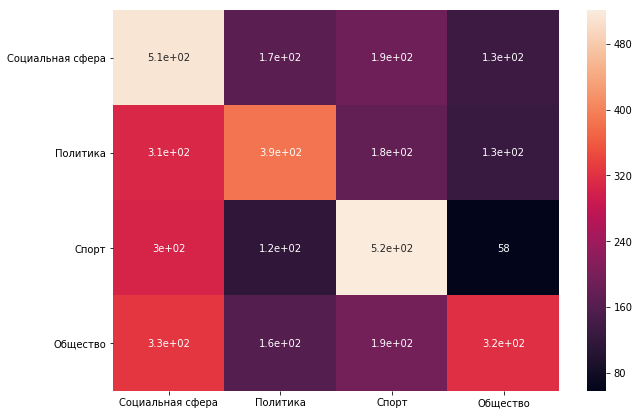

In [0]:
# На всей выборке

X = df.loc[:, df.columns != 'source']
y = df['source']

cm = get_cm(X, y)
plot_cm(cm)
print_metrics_from_cm(cm)

Т.е. качество довольно плохое, несмотря на то, что определённую долю (~ 25%) правильных ответов привносит случайный выбор, потому что мы используем не самые изощрённые правила.

Проверим, есть ли среди наших правил те, которые никогда не ошибаются.

In [0]:
fl_soc_is_not_ideal = 0
fl_politics_is_not_ideal = 0
fl_sport_is_not_ideal = 0
fl_society_is_not_ideal = 0

for index, row in X.iterrows():
    # labels=['Социальная сфера', 'Политика', 'Спорт', 'Общество']
    if y[index] == 'Социальная сфера' and not fl_soc_is_not_ideal:
        if not (set(row['lowered_words']) & {'дом', 'семья', 'жизнь', 'день'}):
            fl_soc_is_not_ideal = 1
            print('rule for social sphere is not ideal')
    elif y[index] == 'Политика' and not fl_politics_is_not_ideal:
        if not (set(row['lowered_words']) & {'администрация', 'глава', 'развитие', 'вопрос', 'рубль'}):
            fl_politics_is_not_ideal = 1
            print('rule for politics is not ideal')
    elif y[index] == 'Спорт' and not fl_sport_is_not_ideal:
        if not (set(row['lowered_words']) & {'почта', 'отделение', 'письмо'}):
            fl_sport_is_not_ideal = 1
            print('rule for sport is not ideal')
    elif not fl_society_is_not_ideal: # y[index] == 'Общество'
        if not (set(row['lowered_words']) & {'полиция', 'мвд', 'москва'}):
            fl_society_is_not_ideal = 1
            print('rule for society is not ideal')

rule for social sphere is not ideal
rule for society is not ideal
rule for sport is not ideal
rule for politics is not ideal


Естественно, ни одно из правил не является идеальным. Можно взять уникальное слово (встречающееся только один раз в данном корпусе или несколько раз, но только в одном корпусе) и создать правило типа "если встретилось это слово, то это категория c (категория, в которой встретилось это слово)", но и оно получено "переобучением" (т.е. мы знали ответы заранее), т.е. не будет универсальным для новых тестовых данных.

Для никогда не ошибающихся правил (но только для данного датасета) можно взять, к примеру, следующие слова:

In [0]:
words = []
for i in range(df.shape[0]):
    words.extend(df.iloc[i]["lowered_words"])

In [0]:
[(key, value) for key, value in Counter(words).items() if value == 1][:15]

[('устраиваться', 1),
 ('смутилась', 1),
 ('неожиданных', 1),
 ('стройматериал', 1),
 ('цементные', 1),
 ('лежащие', 1),
 ('курятник', 1),
 ('выгула', 1),
 ('пазы', 1),
 ('курятника', 1),
 ('промазаны', 1),
 ('нашесты', 1),
 ('заготовленные', 1),
 ('веники', 1),
 ('склевывали', 1)]

## Задание 3 [3 балла]. Baseline
Используйте стандартный ```sklearn.pipeline``` для классификации текстов: 
* векторизация 
* $tf-idf$ взвешивание 
* ваш любимый метод классификации.


Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

In [0]:
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

Мультиномиальный наивный Байес даёт хороший baseline (см., например, лекции, где об этом также говорится), поэтому будем использовать именно этот классификатор. В качестве векторайзера используем BOW (частотности) с tf-idf взвешиванием.

In [0]:
pipeline = Pipeline([('vectorizer', CountVectorizer()), ('tf_idf', TfidfTransformer()), ('classifier', MultinomialNB())], verbose=True)

In [0]:
X_train = X_train_full['text']
X_test = X_test_full['text']

In [0]:
pipeline.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 3) Processing vectorizer, total=   0.7s
[Pipeline] ............ (step 2 of 3) Processing tf_idf, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tf_idf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=True)

In [0]:
predictions = pipeline.predict(X_test)

In [0]:
cm = confusion_matrix(y_test, predictions, labels)

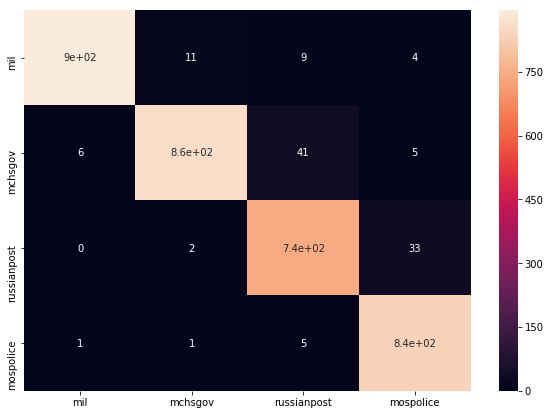

In [0]:
plot_cm(cm)

In [0]:
print_metrics_from_cm(cm)

Mean Precision: 0.9649451149905334
Mean Recall 0.9659590149255644
Accuracy: 0.9658762290341237
F1 score: 0.9654517987633003


In [0]:
print(classification_report(y_test, predictions, labels))

              precision    recall  f1-score   support

         mil       0.99      0.97      0.98       919
     mchsgov       0.98      0.94      0.96       914
 russianpost       0.93      0.96      0.94       780
   mospolice       0.95      0.99      0.97       845

    accuracy                           0.97      3458
   macro avg       0.96      0.97      0.97      3458
weighted avg       0.97      0.97      0.97      3458



Качество выросло значительно.

Как видно из матрицы ошибок чаще всего (41) классификатор ошибочно приписывает лейбл "mchsgov" к текстам, в действительности имеющим лейбл "russianpost". Следующей по частотности ошибкой (33) является приписывание лейбла "russianpost" к текстам, имеющим лейбл "mospolice". 11 раз текстам с лейблом "mchsgov" ошибочно приписывается лейбл "mil". Во всех остальных случаях количество ошибок меньше десяти. Лейблы "mil" и "mospolice" практически не смешиваются (всего 5 раз -- наименьшее количество), т.е. эти два паблика являются наиболее отличающимися.

Попробуем также считающийся лучшим линейный классификатор с обучением с помощью стохастического градиентного спуска (SGD классификатор на дефолтных параметрах).

In [0]:
pipeline = Pipeline([('vectorizer', CountVectorizer()), ('tf_idf', TfidfTransformer()), ('classifier', SGDClassifier())], verbose=True)

In [0]:
pipeline.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 3) Processing vectorizer, total=   0.7s
[Pipeline] ............ (step 2 of 3) Processing tf_idf, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabula...
                ('classifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
              

In [0]:
predictions = pipeline.predict(X_test)

In [0]:
cm = confusion_matrix(y_test, predictions, labels)

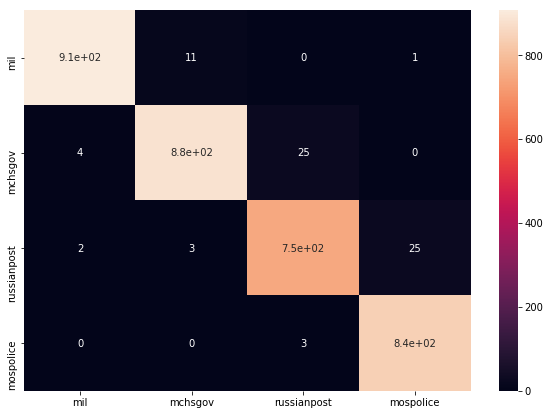

In [0]:
plot_cm(cm)

In [0]:
print_metrics_from_cm(cm)

Mean Precision: 0.9779779413705584
Mean Recall 0.9783004572726648
Accuracy: 0.9786003470213996
F1 score: 0.9781391727363089


In [0]:
print(classification_report(y_test, predictions, labels))

              precision    recall  f1-score   support

         mil       0.99      0.99      0.99       919
     mchsgov       0.98      0.97      0.98       914
 russianpost       0.96      0.96      0.96       780
   mospolice       0.97      1.00      0.98       845

    accuracy                           0.98      3458
   macro avg       0.98      0.98      0.98      3458
weighted avg       0.98      0.98      0.98      3458



Качество стало ещё  лучше.

Аналогично MultinomialNB SGDClassifier также путает "mchsgov" с "russianpost" (23), "russianpost" c "mospolice" (25) и "mil" с "mchsgov" (11), но уже в меньшей мере. Минимум ошибок наблюдается для тем "mchsgov" и "mospolice" (всего 1 ошибка), "mil" и "mospolice" (всего 2 ошибки), "mil" и "russianpost" (также), т.е. классификатор очень даже неплохо обучился отличать посты в отдельных парах. Заранее трудно было предположить, что "mil" и "mospolice" окажутся чётче разграничены, чем, например, "russianpost" c "mospolice", поскольку, к примеру, и в постах про "mil", и в постах про "mospolice" может идти речь, например, о вооружении. Возможно, это связано с нечёткой тематикой у "russianpost".

## Задание 4 [2 балла]. Снижение размерности
Добавьте в ваш ```sklearn.pipeline```  методы снижения размерности:  PCA / LSI / LSA / LDA / другое. Какие методы классификации разумно использовать после снижения размерности? Как изменились результаты классификации после добавления нового шага?

In [0]:
# Используем LSA (латентно-семантический анализ): применяем TruncatedSVD после tf-idf трансформатора.
from sklearn.decomposition import TruncatedSVD

In [0]:
pipeline = Pipeline(steps=[('vectorizer', CountVectorizer()), ('tf_idf', TfidfTransformer()), ('lsa', TruncatedSVD()), ('classifier', SGDClassifier())], verbose=True)
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

[Pipeline] ........ (step 1 of 4) Processing vectorizer, total=   0.7s
[Pipeline] ............ (step 2 of 4) Processing tf_idf, total=   0.1s
[Pipeline] ............... (step 3 of 4) Processing lsa, total=   0.3s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.0s


Mean Precision: 0.598647748981582
Mean Recall 0.643985078108332
Accuracy: 0.6576055523423945
F1 score: 0.6204893496820294


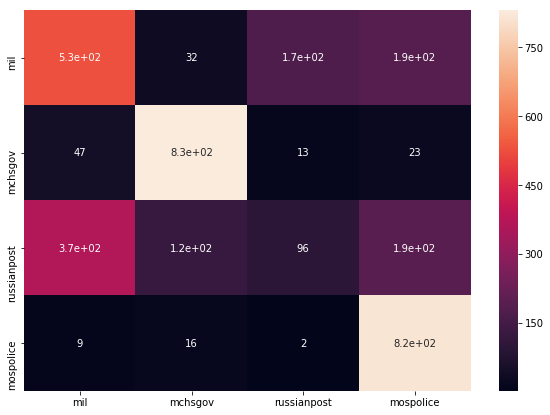

In [0]:
cm = confusion_matrix(y_test, predictions, labels)
plot_cm(cm)
print_metrics_from_cm(cm)

После tf-idf у нас есть sparce матрица, после понижения размерности с помощью, например, PCA, получаем dense матрицу.

SGD классификатор (как и, например, LinearSVC классификатор) явно не подходит для использования после PCA, поскольку он ожидает именно sparce матрицу (это видно и по сильно упавшему качеству выше: даже ниже, чем у предсказания по правилам), а мы сознательно уменьшаем её размерность. MultinomialNB в принципе выдаёт ошибку из-за несовместимости.

Поэтому разумно использовать классификаторы, которые ожидают на вход именно dense матрицу. Среди таковых, например, случайный лес (RandomForestClassifier()), 

In [0]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[('vectorizer', CountVectorizer()), ('tf_idf', TfidfTransformer()), ('lsa', TruncatedSVD()), ('classifier', RandomForestClassifier())], verbose=True)

In [0]:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

[Pipeline] ........ (step 1 of 4) Processing vectorizer, total=   0.7s
[Pipeline] ............ (step 2 of 4) Processing tf_idf, total=   0.1s
[Pipeline] ............... (step 3 of 4) Processing lsa, total=   0.3s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.1s


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Precision: 0.7339045360883352
Mean Recall 0.7377622903666792
Accuracy: 0.7446500867553499
F1 score: 0.7358283569648381


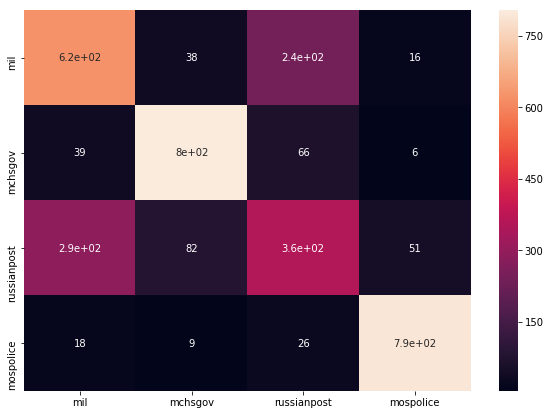

In [0]:
cm = confusion_matrix(y_test, predictions, labels)
plot_cm(cm)
print_metrics_from_cm(cm)

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
pipeline = Pipeline(steps=[('vectorizer', CountVectorizer()), ('tf_idf', TfidfTransformer()), ('lsa', TruncatedSVD()), ('classifier', LogisticRegression())], verbose=True)
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

[Pipeline] ........ (step 1 of 4) Processing vectorizer, total=   0.7s
[Pipeline] ............ (step 2 of 4) Processing tf_idf, total=   0.1s
[Pipeline] ............... (step 3 of 4) Processing lsa, total=   0.3s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


Mean Precision: nan
Mean Recall 0.6622567883735277
Accuracy: 0.6827646038172354
F1 score: nan


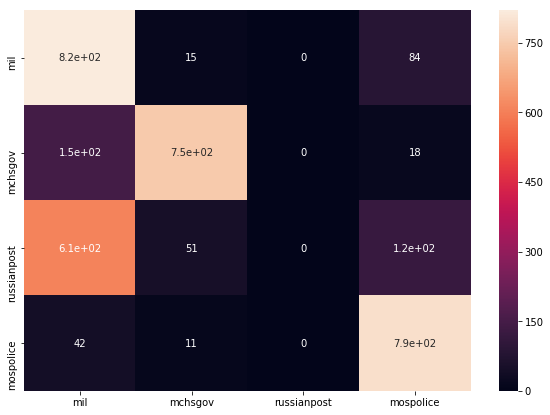

In [0]:
# Вдобавок появляются nan-ы
cm = confusion_matrix(y_test, predictions, labels)
plot_cm(cm)
print_metrics_from_cm(cm)

In [0]:
print(classification_report(y_test, predictions, labels))

              precision    recall  f1-score   support

         mil       0.51      0.89      0.65       919
     mchsgov       0.91      0.82      0.86       914
 russianpost       0.00      0.00      0.00       780
   mospolice       0.78      0.94      0.85       845

    accuracy                           0.68      3458
   macro avg       0.55      0.66      0.59      3458
weighted avg       0.57      0.68      0.61      3458



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
from sklearn.ensemble import AdaBoostClassifier

In [0]:
pipeline = Pipeline(steps=[('vectorizer', CountVectorizer()), ('tf_idf', TfidfTransformer()), ('lsa', TruncatedSVD()), ('classifier', AdaBoostClassifier())], verbose=True)
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

[Pipeline] ........ (step 1 of 4) Processing vectorizer, total=   0.7s
[Pipeline] ............ (step 2 of 4) Processing tf_idf, total=   0.1s
[Pipeline] ............... (step 3 of 4) Processing lsa, total=   0.3s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.6s


Mean Precision: 0.6727494441397254
Mean Recall 0.6406890034682112
Accuracy: 0.6561596298438404
F1 score: 0.6563279333487804


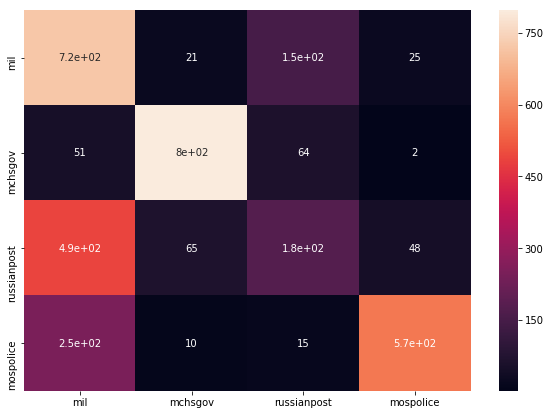

In [0]:
cm = confusion_matrix(y_test, predictions, labels)
plot_cm(cm)
print_metrics_from_cm(cm)

Качестве лучше, чем у SGDClassifier-а, но по-прежнему оставляет желать лучшего (впрочем, случайный лес и другие выше используемые алгоритмы в принципе обчно хуже, чем SGD классификатор на sparce матрицах). Т.е. результаты ухудшились после добавления нового шага. Нет смысла терять информацию, понижая размерность, если в данной задаче хватает памяти, чтобы хранить sparse матрицы.

## Задание 5 [1 балл]. Лемматизация
Посмотрите, как влияет лемматизация на качество классификации. Как изменится качество классификации, если вы используете ```CountVectorizer``` на словах или $n$-граммах на лемматизированных текстах?

In [0]:
X_train = X_train_full['lemmatized_text']
X_test = X_test_full['lemmatized_text']

In [0]:
pipeline = Pipeline([('vectorizer', CountVectorizer()), ('tf_idf', TfidfTransformer()), ('classifier', SGDClassifier())], verbose=True)
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

[Pipeline] ........ (step 1 of 3) Processing vectorizer, total=   0.5s
[Pipeline] ............ (step 2 of 3) Processing tf_idf, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s


Mean Precision: 0.9777910494287504
Mean Recall 0.9778636297507506
Accuracy: 0.9783111625216888
F1 score: 0.9778273382429117


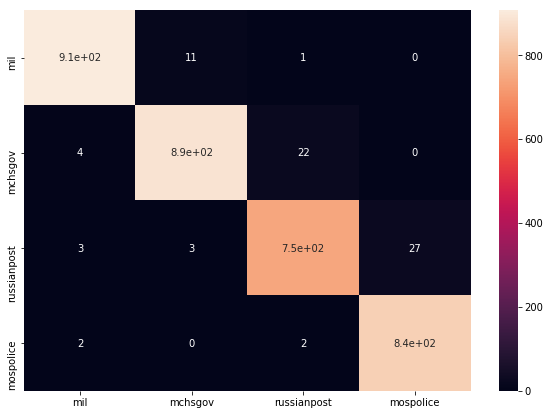

In [0]:
cm = confusion_matrix(y_test, predictions, labels)
plot_cm(cm)
print_metrics_from_cm(cm)

In [0]:
print(classification_report(y_test, predictions, labels))

              precision    recall  f1-score   support

         mil       0.99      0.99      0.99       919
     mchsgov       0.98      0.97      0.98       914
 russianpost       0.97      0.96      0.96       780
   mospolice       0.97      1.00      0.98       845

    accuracy                           0.98      3458
   macro avg       0.98      0.98      0.98      3458
weighted avg       0.98      0.98      0.98      3458



На лемматизированных текстах результат лучше, хотя, возможно, это в пределах погрешности, т.к. превосходит незначительно. По цифрам в матрице ошибок всё не так однозначно, кое-где стало немного больше ошибок, кое-где наоборот немного меньше.

Попробуем использовать n-граммы с n<=5 и посмотрим на качество.

In [0]:
n = 5
pipeline = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1, n))), ('tf_idf', TfidfTransformer()), ('classifier', SGDClassifier())], verbose=True)
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

[Pipeline] ........ (step 1 of 3) Processing vectorizer, total=  14.2s
[Pipeline] ............ (step 2 of 3) Processing tf_idf, total=   0.8s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   1.2s


Mean Precision: 0.978285092408903
Mean Recall 0.9785963152608305
Accuracy: 0.9788895315211105
F1 score: 0.9784406790863911


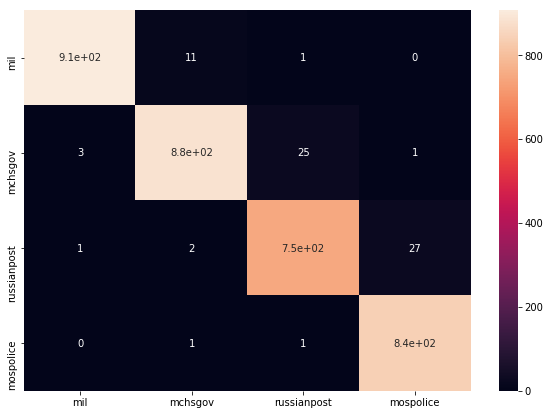

In [0]:
cm = confusion_matrix(y_test, predictions, labels)
plot_cm(cm)
print_metrics_from_cm(cm)

In [0]:
print(classification_report(y_test, predictions, labels))

              precision    recall  f1-score   support

         mil       1.00      0.99      0.99       919
     mchsgov       0.98      0.97      0.98       914
 russianpost       0.97      0.96      0.96       780
   mospolice       0.97      1.00      0.98       845

    accuracy                           0.98      3458
   macro avg       0.98      0.98      0.98      3458
weighted avg       0.98      0.98      0.98      3458



Качество естественным образом улучшилось, хоть и незначительно.

## Задание 6 [3 балла]. Continuous bag of words
Для baseline решения мы использовали обычное представление текста в виде мешка слов. Попробуйте использовать другие модели представления текста – например, в виде непрерывного мешка слов, то есть, в виде набора эмбеддингов. Для того, чтобы получить вектор текста попробуйте:
* усреднить все эмбеддинги слов, входящих в этот текст
* усреднить все эмбеддинги слов, входящих в этот текст с $tf-idf$ весами
* использовать любую модель эмбеддинга документа.

Используйте любую модель эмбеддингов по вашему вкусу. 


Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

Также используем лемматизированные тексты, поскольку на них качество получше (см. задание 5).

In [0]:
# training word2vec model
from gensim.models import Word2Vec

In [0]:
size_of_embedding = 300
corpus = df['lemmatized_words']

In [0]:
# set parameters and seed
model = Word2Vec(corpus, size=size_of_embedding, window=7, min_count=0, iter=10, workers=4, seed=21)
model.wv.init_sims(replace=True) # save only normalized vectors
model.save("word2vec.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
word_vectors = model.wv

In [0]:
corpus_vectors = []
for num_text, text in enumerate(corpus):
    corpus_vectors.append([])
    for word in text:
        corpus_vectors[num_text].append(word_vectors[word])

In [0]:
# усреднить все эмбеддинги слов, входящих в этот текст

docs_vectors = np.zeros(shape=(len(corpus), size_of_embedding))
for num_text in range(len(corpus)):
    docs_vectors[num_text] = np.sum(corpus_vectors[num_text], axis=0) / len(corpus_vectors[num_text])

In [0]:
docs_vectors.shape

(11526, 300)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(docs_vectors, df['source'], test_size=0.3, random_state=21)

In [0]:
clf = SGDClassifier().fit(X_train, y_train)

In [0]:
predictions = clf.predict(X_test)

Mean Precision: 0.9269445056618801
Mean Recall 0.9282003832492873
Accuracy: 0.9274146905725853
F1 score: 0.9275720193598072


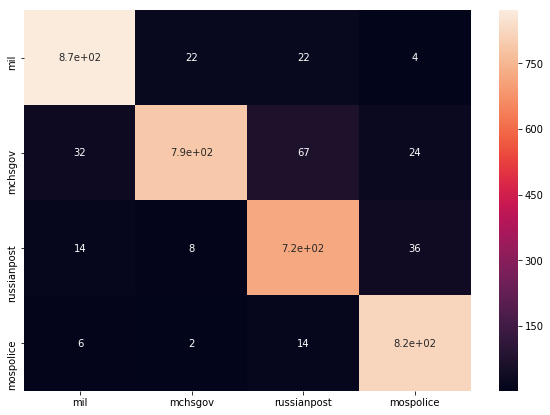

In [0]:
cm = confusion_matrix(y_test, predictions, labels)
plot_cm(cm)
print_metrics_from_cm(cm)

In [0]:
print(classification_report(y_test, predictions, labels))

              precision    recall  f1-score   support

         mil       0.94      0.95      0.95       919
     mchsgov       0.96      0.87      0.91       914
 russianpost       0.88      0.93      0.90       780
   mospolice       0.93      0.97      0.95       845

    accuracy                           0.93      3458
   macro avg       0.93      0.93      0.93      3458
weighted avg       0.93      0.93      0.93      3458



Качество гораздо хуже, чем у baseline в задании 3-м, поскольку среднее векторов документа (без весов, вернее, с одинаковыми весами == 1 / n, где n -- количество слов в документе) не является очень хорошим представлением документа. Ошибки по большей части те же, хотя добавляются новые (например, "mospolice" ошибочно атрибутируется статьям с тематикой "mospolice").

In [0]:
# функция для подсчёта tf слов в документе
def tfs(words):
    tf = Counter(words)
    return [tf[word] / len(words) for word in words]

In [0]:
import math

# функция для подсчёта idf слова в документе
def idf(word, corpus):
    return math.log10(len(corpus) / (1 + len([1 for text in corpus if word in text]))) # added 1 so that we don't divide by zero

In [0]:
# усреднить все эмбеддинги слов, входящих в этот текст, с 𝑡𝑓−𝑖𝑑𝑓 весами

# считает очень долго, поэтому отказываемся от "ручного" подсчёта tf-idf
# docs_vectors = np.zeros(shape=(len(corpus), size_of_embedding))
# for num_text, text in enumerate(corpus):
#     print(num_text)
#     term_frequencies = tfs(text)
#     for num_word in range(len(term_frequencies)):
#         tf_word = term_frequencies[num_word]
#         idf_word = idf(corpus[num_text][num_word], corpus)
#         docs_vectors[num_text] += tf_word * idf_word * corpus_vectors[num_text][num_word]

In [0]:
# вместо этого используем TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
# используем тот же токенизатор, что и при подсчёте уникальных слов в первом задании
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=word_tokenize)
tfidf_matrix = vectorizer.fit_transform(df['lemmatized_text'])

In [0]:
tfidf_matrix.shape

(11526, 39292)

In [0]:
feature_names = vectorizer.get_feature_names()

In [0]:
# все слова сохранились, т.е. ошибок быть не должно
'в' in feature_names

True

In [0]:
docs_vectors = np.zeros(shape=(len(corpus), size_of_embedding))
for num_text in range(len(corpus)):
    print(num_text)

    # get not-null word indices (columns)
    word_indices = tfidf_matrix[num_text, :].nonzero()[1]

    for word_index, word in enumerate(corpus[num_text]):
        index = feature_names.index(word)
        tf_idf = tfidf_matrix[num_text, index]
        # считаем tf-idf взвешенное векторов слов в документе
        docs_vectors[num_text] += corpus_vectors[num_text][word_index] * tf_idf

# print(len([tfidf_matrix[doc, word_index] for word_index in word_indices]))

In [0]:
docs_vectors.shape

(11526, 300)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(docs_vectors, df['source'], test_size=0.3, random_state=21)

In [0]:
clf = SGDClassifier().fit(X_train, y_train)

In [0]:
predictions = clf.predict(X_test)

Mean Precision: 0.93741657835195
Mean Recall 0.9376751753303098
Accuracy: 0.9384037015615962
F1 score: 0.9375458590093633


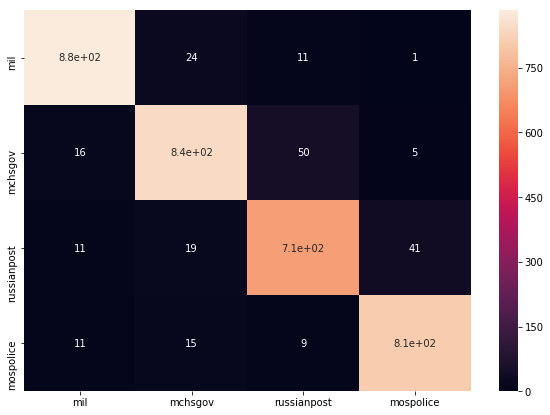

In [0]:
cm = confusion_matrix(y_test, predictions, labels)
plot_cm(cm)
print_metrics_from_cm(cm)

In [0]:
print(classification_report(y_test, predictions, labels))

              precision    recall  f1-score   support

         mil       0.96      0.96      0.96       919
     mchsgov       0.94      0.92      0.93       914
 russianpost       0.91      0.91      0.91       780
   mospolice       0.95      0.96      0.95       845

    accuracy                           0.94      3458
   macro avg       0.94      0.94      0.94      3458
weighted avg       0.94      0.94      0.94      3458



Качество улучшилось примерно на процент, т.е. tf-idf взвешивание даёт более точное представление вектора документа, но всё же оно далеко от идеала (см. качество в задании 3, хотя там используется совершенно другой подход). Самые популярные ошибки совпадают с описывавшимися в задании 3. Также > 11 ошибок (минимум 12 наблюдается на постах с лейблами "mil" и "mospolice") наблюдается в каждой паре.

In [0]:
# использовать любую модель эмбеддинга документа.

# используем Doc2Vec из библиотеки gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 

In [0]:
# приводим к нужному формату документы
docs = [TaggedDocument(words=df.loc[num_text, "lemmatized_words"], tags=[num_text]) for num_text in range(len(corpus))]

In [0]:
# dm == 0 => используем PV-DBOW (не сохраняем порядок)
model = Doc2Vec(vector_size=size_of_embedding, window=300, min_count=1, workers=4)

In [0]:
model.build_vocab(docs)

In [0]:
# обучаем только в течение 5 эпох, т.к. обучается долго
for epoch in range(5):
    model.train(docs,
                total_examples=model.corpus_count,
                epochs=model.iter)

In [0]:
len(model.docvecs)

11526

In [0]:
X_train, X_test, y_train, y_test = train_test_split(model.docvecs, df['source'], test_size=0.3, random_state=21)

Mean Precision: 0.40766598434245493
Mean Recall 0.39668604189910367
Accuracy: 0.4068825910931174
F1 score: 0.4021010713464528


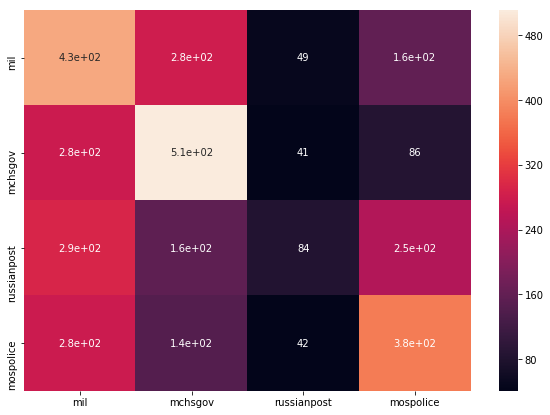

In [0]:
clf = SGDClassifier().fit(X_train, y_train)
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels)
plot_cm(cm)
print_metrics_from_cm(cm)

In [0]:
print(classification_report(y_test, predictions, labels))

              precision    recall  f1-score   support

         mil       0.34      0.47      0.39       919
     mchsgov       0.47      0.56      0.51       914
 russianpost       0.39      0.11      0.17       780
   mospolice       0.44      0.45      0.44       845

    accuracy                           0.41      3458
   macro avg       0.41      0.40      0.38      3458
weighted avg       0.41      0.41      0.39      3458



Как видно, подход с эмбеддингами не смог предоставить качество лучше, чем в задании 3. На большем количестве эпох качество было бы лучше, но векторы обучаются очень долго, поэтому для демонстрации мы ограничились 5 эпохами. На 5 эпохах ошибок очень много: качество гораздо хуже, чем классификация по правилам.

## Задание 7 [2 балла]. fastText

Используйте ```fastText``` в режиме классификации. Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

In [0]:
# !pip install fasttext
import fasttext

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_text'], df['source'], test_size=0.3, random_state=21)

In [0]:
with open('train.txt', 'w', encoding='utf-8') as f:
    for text, target in zip(X_train, y_train):
        f.write("__label__" + target + ' ' + text + '\n')

In [0]:
with open('test.txt', 'w', encoding='utf-8') as f:
    for text, target in zip(X_test, y_test):
        f.write("__label__" + target + ' ' + text + '\n')

In [0]:
classifier = fasttext.supervised('train.txt', 'model', label_prefix='__label__')

In [0]:
result = classifier.test('test.txt')

In [0]:
print('P@1:', result.precision)
print('R@1:', result.recall)
print('Number of examples:', result.nexamples)

P@1: 0.9707923655292077
R@1: 0.9707923655292077
Number of examples: 3458


In [0]:
predictions = [label[0] for label in classifier.predict(X_test)]

Mean Precision: 0.9701733267776453
Mean Recall 0.9703020054733031
Accuracy: 0.9707923655292077
F1 score: 0.9702376618589406


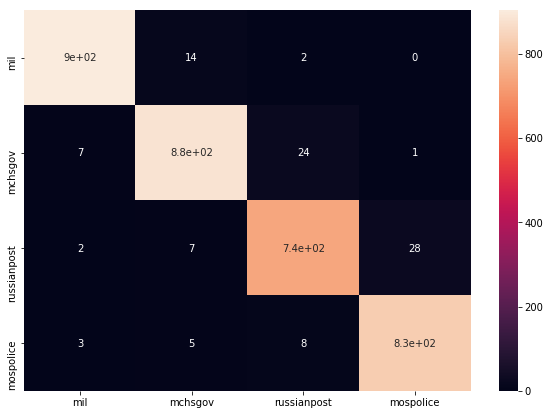

In [0]:
cm = confusion_matrix(y_test, predictions, labels)
plot_cm(cm)
print_metrics_from_cm(cm)

In [0]:
print(classification_report(y_test, predictions, labels))

              precision    recall  f1-score   support

         mil       0.99      0.98      0.98       919
     mchsgov       0.97      0.96      0.97       914
 russianpost       0.96      0.95      0.95       780
   mospolice       0.97      0.98      0.97       845

    accuracy                           0.97      3458
   macro avg       0.97      0.97      0.97      3458
weighted avg       0.97      0.97      0.97      3458



Качество немного меньше, чем в 7-м задании (в среднем на 0.7 по метрикам).

Здесь частотнее ошибка с атрибуцией 'russianpost' к текстам с лейблом 'mospolice'. Самыми разграниченными классами также (как и во многих случаях выше) является пара 'mospolice' и 'mil'. Как видно из confusion matrix выше, ошибки те же самые, только с немного другими пропорциями, поэтому пересказывать не буду.

## Задание 8 [4 балла]. CNN

Реализуйте модель Kim et al (2014) для решения задачи классификации с помощью CNN. Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix).
Ссылка: Kim Y. Convolutional Neural Networks for Sentence Classification. 2014

In [0]:
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.utils import np_utils

import numpy as np

np.random.seed(21) # for reproducibility

Using TensorFlow backend.


In [0]:
# set hyperparameters
TEXT_LENGTH = 1800
VOCABULARY_SIZE = 250000
EMBEDDING_DIM = 300
batch_size = 32
nb_epoch = 50

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_text'], df['source'], test_size=0.3, random_state=21)

In [0]:
# токенизируем и фитим на обучающих текстах
tokenizer = Tokenizer(num_words=TEXT_LENGTH)
tokenizer.fit_on_texts(X_train.values)

In [0]:
# sequence --> matrix
sequences = tokenizer.texts_to_sequences(X_train.values)
X_train = tokenizer.sequences_to_matrix(sequences, mode='count')
sequences = tokenizer.texts_to_sequences(X_test.values)
X_test = tokenizer.sequences_to_matrix(sequences, mode='count')

In [0]:
print('First seq:', sequences[0])
print('First doc:', X_test[0])

First seq: [1321, 256, 558, 4, 272, 884, 89, 987, 3, 140, 246, 253, 4, 44, 356, 353, 1, 1, 2, 82, 420, 126, 1128, 1782, 261, 281, 6, 1062, 566, 13, 65, 1157, 433, 13, 775, 1128, 1311, 433, 1157, 3, 433, 1722, 2, 125, 1, 1, 2, 420, 1783, 597, 775, 1763, 137, 433, 6, 1034, 1145, 453, 216, 261, 13, 356, 5, 566, 253, 4, 579, 283, 353, 1, 1, 60, 558, 1157, 464]
First doc: [0. 6. 3. ... 0. 0. 0.]


In [0]:
# one-hot кодируем целевую переменную, создавая LabelEncoder
le = LabelEncoder()
classes = y_train.unique()
le.fit(classes)
y_formatted_train = np_utils.to_categorical(le.transform(y_train), len(classes))
y_formatted_test = np_utils.to_categorical(le.transform(y_test), len(classes))
y_formatted_true = le.transform(y_test)
print(y_formatted_train[0]) # example

[1. 0. 0. 0.]


In [0]:
# Пробуем архитектуру
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE,
                    EMBEDDING_DIM,
                    input_length=TEXT_LENGTH,
                    trainable=True))
model.add(Conv1D(128, len(classes), activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(len(classes), activation='softmax'))
# специфицирует метрику, алгоритм обновления параметров и функцию потерь
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1800, 300)         75000000  
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1797, 128)         153728    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 898, 128)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 898, 128)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 114944)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 459780    
Total params: 75,613,508
Trainable params: 75,613,508
Non-trainable params: 0
________________________________________________________________

In [0]:
model.fit(X_train, y_formatted_train, epochs=nb_epoch, batch_size=batch_size, validation_split=0.1)

Train on 7261 samples, validate on 807 samples
Epoch 1/50
7261/7261 [==============================] - 19s 3ms/step - loss: 0.2830 - acc: 0.9192 - val_loss: 0.1309 - val_acc: 0.9566
Epoch 2/50
7261/7261 [==============================] - 17s 2ms/step - loss: 0.0869 - acc: 0.9785 - val_loss: 0.1291 - val_acc: 0.9653
Epoch 3/50
7261/7261 [==============================] - 17s 2ms/step - loss: 0.0543 - acc: 0.9864 - val_loss: 0.1502 - val_acc: 0.9603
Epoch 4/50
7261/7261 [==============================] - 17s 2ms/step - loss: 0.0365 - acc: 0.9912 - val_loss: 0.1943 - val_acc: 0.9529
Epoch 5/50
7261/7261 [==============================] - 17s 2ms/step - loss: 0.0291 - acc: 0.9919 - val_loss: 0.2024 - val_acc: 0.9628
Epoch 6/50
7261/7261 [==============================] - 17s 2ms/step - loss: 0.0358 - acc: 0.9923 - val_loss: 0.1643 - val_acc: 0.9616
Epoch 7/50
7261/7261 [==============================] - 17s 2ms/step - loss: 0.0258 - acc: 0.9945 - val_loss: 0.2213 - val_acc: 0.9492
Epoch 8/

In [0]:
y_pred = model.predict_classes(X_test)
predictions = le.inverse_transform(y_pred)

Mean Precision: 0.9520427944784393
Mean Recall 0.9515522761884496
Accuracy: 0.9522845575477155
F1 score: 0.9517974721350793


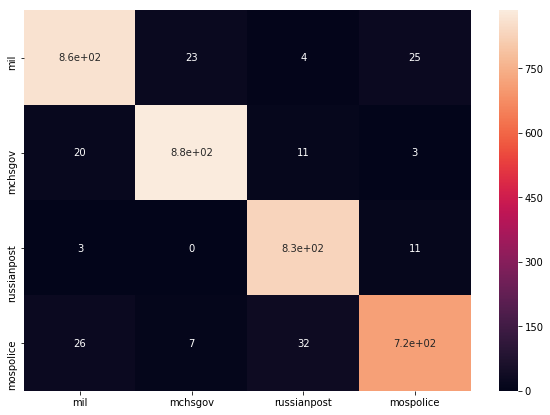

In [0]:
cm = confusion_matrix(y_test, predictions, classes)
plot_cm(cm)
print_metrics_from_cm(cm)

In [0]:
print(classification_report(y_test, predictions, classes))

              precision    recall  f1-score   support

     mchsgov       0.95      0.94      0.94       914
         mil       0.97      0.96      0.97       919
   mospolice       0.95      0.98      0.96       845
 russianpost       0.95      0.92      0.93       780

    accuracy                           0.95      3458
   macro avg       0.95      0.95      0.95      3458
weighted avg       0.95      0.95      0.95      3458



Судя по метрикам на валидирующей выборке, качество не увеличивается (нестабильно, скачет туда-сюда) на протяжении многих эпох, поэтому достаточно было меньшего количества эпох. Также, по-видимому, архитектура подобрана не самым удачным образом, поэтому попробуем её поменять, обучить на 10 эпохах и посмотреть на качество.

In [0]:
nb_epoch = 10

In [0]:
# удалил dropout, поскольку, на мой взгляд, нет смысла выбрасывать ценную информацию в данной задаче
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE,
                    EMBEDDING_DIM,
                    input_length=TEXT_LENGTH,
                    trainable=True))
model.add(Conv1D(512, len(classes), activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(256, len(classes), activation='relu'))
model.add(Flatten())
model.add(Dense(len(classes), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1800, 300)         75000000  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1797, 512)         614912    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 898, 512)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 895, 256)          524544    
_________________________________________________________________
flatten_9 (Flatten)          (None, 229120)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 916484    
Total params: 77,055,940
Trainable params: 77,055,940
Non-trainable params: 0
________________________________________________________________

In [0]:
model.fit(X_train, y_formatted_train, epochs=nb_epoch, batch_size=batch_size, validation_split=0.1)

Train on 7261 samples, validate on 807 samples
Epoch 1/10
7261/7261 [==============================] - 34s 5ms/step - loss: 0.3399 - acc: 0.8955 - val_loss: 0.1409 - val_acc: 0.9653
Epoch 2/10
7261/7261 [==============================] - 31s 4ms/step - loss: 0.0935 - acc: 0.9760 - val_loss: 0.1562 - val_acc: 0.9641
Epoch 3/10
7261/7261 [==============================] - 32s 4ms/step - loss: 0.0553 - acc: 0.9850 - val_loss: 0.1642 - val_acc: 0.9529
Epoch 4/10
7261/7261 [==============================] - 32s 4ms/step - loss: 0.0422 - acc: 0.9888 - val_loss: 0.1673 - val_acc: 0.9678
Epoch 5/10
7261/7261 [==============================] - 32s 4ms/step - loss: 0.0230 - acc: 0.9937 - val_loss: 0.1900 - val_acc: 0.9641
Epoch 6/10
7261/7261 [==============================] - 32s 4ms/step - loss: 0.0202 - acc: 0.9944 - val_loss: 0.3280 - val_acc: 0.9504
Epoch 7/10
7261/7261 [==============================] - 32s 4ms/step - loss: 0.0298 - acc: 0.9924 - val_loss: 0.3202 - val_acc: 0.9368
Epoch 8/

In [0]:
y_pred = model.predict_classes(X_test)
predictions = le.inverse_transform(y_pred)

Mean Precision: 0.9558349828975472
Mean Recall 0.9562132215143055
Accuracy: 0.9566223250433776
F1 score: 0.9560240647946177


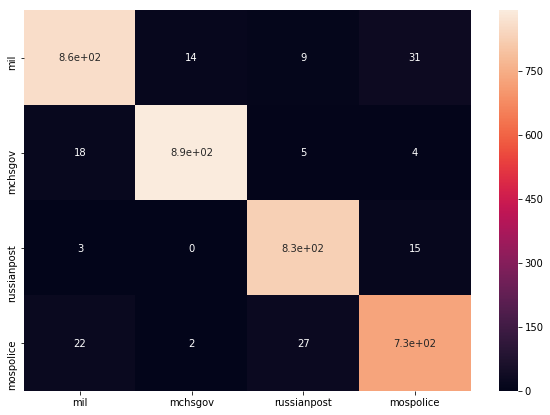

In [0]:
cm = confusion_matrix(y_test, predictions, classes)
plot_cm(cm)
print_metrics_from_cm(cm)

Качество чуть получше, чем на предыдущей архитектуре, но всё равно далеко от baseline-а. Возможно, на лучше подобранной архитектуре и на большем количестве эпох качество было бы получше.

Попобуем ещё следующую архитектуру:

In [0]:
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE,
                    EMBEDDING_DIM,
                    input_length=TEXT_LENGTH,
                    trainable=True))

model.add(Conv1D(512, len(classes), activation='relu'))
model.add(Conv1D(256, len(classes), activation='relu'))
model.add(MaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1800, 300)         75000000  
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 1797, 512)         614912    
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 1794, 256)         524544    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 897, 256)          0         
_________________________________________________________________
dense_12 (Dense)             (None, 897, 128)          32896     
_________________________________________________________________
dense_13 (Dense)             (None, 897, 64)           8256      
_________________________________________________________________
flatten_11 (Flatten)         (None, 57408)             0         
__________

In [0]:
model.fit(X_train, y_formatted_train, epochs=nb_epoch, batch_size=batch_size, validation_split=0.1)

Train on 7261 samples, validate on 807 samples
Epoch 1/10
7261/7261 [==============================] - 41s 6ms/step - loss: 0.3184 - acc: 0.8948 - val_loss: 0.1439 - val_acc: 0.9591
Epoch 2/10
7261/7261 [==============================] - 39s 5ms/step - loss: 0.0981 - acc: 0.9749 - val_loss: 0.1413 - val_acc: 0.9641
Epoch 3/10
7261/7261 [==============================] - 40s 5ms/step - loss: 0.0504 - acc: 0.9893 - val_loss: 0.2055 - val_acc: 0.9554
Epoch 4/10
7261/7261 [==============================] - 39s 5ms/step - loss: 0.0424 - acc: 0.9904 - val_loss: 0.2647 - val_acc: 0.9343
Epoch 5/10
7261/7261 [==============================] - 40s 5ms/step - loss: 0.0313 - acc: 0.9926 - val_loss: 0.3130 - val_acc: 0.9380
Epoch 6/10
7261/7261 [==============================] - 39s 5ms/step - loss: 0.0272 - acc: 0.9941 - val_loss: 0.2430 - val_acc: 0.9542
Epoch 7/10
7261/7261 [==============================] - 39s 5ms/step - loss: 0.0307 - acc: 0.9931 - val_loss: 0.2176 - val_acc: 0.9442
Epoch 8/

In [0]:
y_pred = model.predict_classes(X_test)
predictions = le.inverse_transform(y_pred)

Mean Precision: 0.9529537175436749
Mean Recall 0.9531128404342617
Accuracy: 0.9537304800462695
F1 score: 0.953033272346993


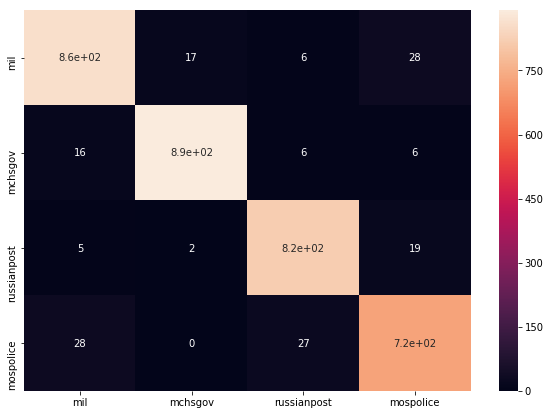

In [0]:
cm = confusion_matrix(y_test, predictions, classes)
plot_cm(cm)
print_metrics_from_cm(cm)

Здесь качество ещё больше упало. Самой частотной парой является, как ни странно, пара "mospolice" - "mil", хотя на методах без использования нейросетей именно в ней реже всего ошибались модели, т.е. это в очередной раз свидетельствует о сильно отличающихся подходах к решению задачи классификации.

В случае с CNN, много ошибок также в парах "russianpost" - "mospolice" и "mchsgoc" - "mil", что было характерно не в такой мере для подходов без использования нейронных сетей.

## Задание 9 [4 + 2 балла]. RNN

(4 балла)Используйте ```RNN``` (BLSTM с какими-то признаками и пулинг поверх) для решения задачи текстовой классификации. Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix).

За дополнительные 2 балла добавьте в модель символьные признаки - CharCNN или CharRNN

In [0]:
from keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D
from keras.preprocessing import sequence

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_text'], df['source'], test_size=0.3, random_state=21)

In [0]:
tokenizer = Tokenizer(num_words=TEXT_LENGTH)
tokenizer.fit_on_texts(X_train.values)

In [0]:
# падим последовательности для одинаковой длины (не больше TEXT_LENGTH=1800) всех входных последовательностей
sequences = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(sequences, maxlen=TEXT_LENGTH, padding='post')
sequences = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(sequences, maxlen=TEXT_LENGTH, padding='post')

In [0]:
le = LabelEncoder()
classes = y_train.unique()
le.fit(classes)
y_formatted_train = np_utils.to_categorical(le.transform(y_train), len(classes))
y_formatted_test = np_utils.to_categorical(le.transform(y_test), len(classes))
y_formatted_true = le.transform(y_test)
print(y_formatted_train[0])

[1. 0. 0. 0.]


In [0]:
# архитектура с BiLSTM и maxpooling-ом после
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE,
                    EMBEDDING_DIM,
                    input_length=TEXT_LENGTH,
                    trainable=True))
# конктенируем вывод из LStM по левому и правому контекстам
model.add(Bidirectional(LSTM(10, return_sequences=True), merge_mode='concat', weights=None))
model.add(GlobalMaxPooling1D())
model.add(Dense(len(classes), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1800, 300)         75000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1800, 20)          24880     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 84        
Total params: 75,024,964
Trainable params: 75,024,964
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X_train, y_formatted_train, validation_data=(X_test, y_formatted_test), epochs=1, batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 8068 samples, validate on 3458 samples
Epoch 1/1
8068/8068 [==============================] - 1508s 187ms/step - loss: 0.4640 - acc: 0.9160 - val_loss: 0.1509 - val_acc: 0.9717


In [0]:
y_pred = model.predict_classes(X_test)
predictions = le.inverse_transform(y_pred)

Mean Precision: 0.9712467686326223
Mean Recall 0.9710383553094037
Accuracy: 0.97165991902834
F1 score: 0.9711425507893093


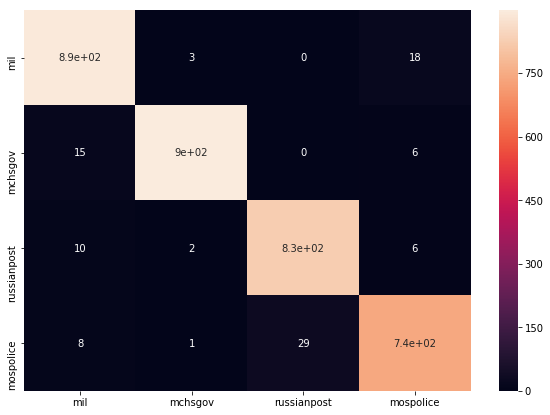

In [0]:
cm = confusion_matrix(y_test, predictions, classes)
plot_cm(cm)
print_metrics_from_cm(cm)

Примерно на 0.06 хуже, чем у SGDClassifier-а в 3-м задании, но мы обучали только на одной эпохе (т.к. обучение очень долгое), поэтому результат скорее всего мог быть и лучше при большем количестве эпох.

Ошибки те же, что и в CNN, но с немного другими пропорциями. Любопытно, что в паре russianpost ~ mchsgov практически нет ошибок (всего 2), хотя для моделей без использования нейронных сетей составляет трудность не путать два этих класса.

Чтобы добавить символьные признаки воспользуемся реализацией объединённого эмбеддинга для слова и симольных признаков в библиотеке keras_wc_embd

In [0]:
# !pip install keras-word-char-embd
from keras_wc_embd import WordCharEmbd

In [0]:
wc_embd = WordCharEmbd(word_min_freq=0, char_min_freq=0, word_ignore_case=True, char_ignore_case=True)

In [0]:
corpus = df['lemmatized_text']
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_text'], df['source'], test_size=0.3, random_state=21)

In [0]:
for sentence in corpus:
    wc_embd.update_dicts(sentence)

In [0]:
inputs, embd_layer = wc_embd.get_embedding_layer(word_mask_zero=False, char_mask_zero=False)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
blstm_layer = Bidirectional(LSTM(10, return_sequences=True), merge_mode='concat', weights=None)(embd_layer)
next_layer = GlobalMaxPooling1D()(blstm_layer)
softmax_layer = Dense(len(classes), activation='softmax')(next_layer)
model = Model(inputs=inputs, outputs=softmax_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Char (InputLayer)         (None, None, 1)      0                                            
__________________________________________________________________________________________________
Input_Word (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
Embedding_Char_Pre (Embedding)  (None, None, 1, 30)  5400        Input_Char[0][0]                 
__________________________________________________________________________________________________
Embedding_Word (Embedding)      (None, None, 300)    54000       Input_Word[0][0]                 
__________________________________________________________________________________________________
Embedding_

In [0]:
def batch_generator(corpus):
    while True:
        yield wc_embd.get_batch_input(corpus), np.asarray([0, 1])

In [0]:
model.fit_generator(
    generator=batch_generator(X_train),
    steps_per_epoch=20,
    epochs=1,
)

К сожалению, ядро (даже GPU) умирает, поэтому обучить в колабе, используя эту библиотеку, не получится.

## Задание 10 [8 баллов]. ULMFit

Используйте ```ULMFit``` для решения задачи классификации. Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

In [0]:
# !pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
# !pip install fastai

In [0]:
# подключаем необходимые библиотеки с реализованной ULMFiT (SOTA-моделью для текстовой классификации).
import fastai
from fastai import *
from fastai.text import *

In [0]:
# приведём к датафрейму с нужными названиями колонок (label и text)
tmp_df = pd.DataFrame({'label':df.source, 'text':df.lemmatized_words})

In [0]:
# train_test_split на обучающий датафрейм и датафрейм для валидации
df_trn, df_val = train_test_split(tmp_df, stratify=tmp_df['label'], test_size=0.3, random_state=21)

In [0]:
df_trn.shape, df_val.shape

((8068, 2), (3458, 2))

In [0]:
# получаем из датасетов языковая модель из датафрейма
data_lm = TextLMDataBunch.from_df(train_df=df_trn, valid_df=df_val, path="")

In [0]:
# получаем из датасетов модель для классификации
data_clas = TextClasDataBunch.from_df(path="", train_df=df_trn, valid_df=df_val, vocab=data_lm.train_ds.vocab, bs=24)

In [0]:
# LanguageLearner
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.5)

In [0]:
# своего рода регуляризация для улучшений качества (скорость обучения = 0.01)
learn.fit_one_cycle(cyc_len=1, max_lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.584808,1.492893,0.785894,03:06


In [0]:
# сохраняем encoder
learn.save_encoder('encoder')

In [0]:
# используем data_clas, чтобы построить классификатор с помощью сохранённого encoder-а
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)

In [0]:
# загружаем encoder
learn.load_encoder('encoder')

In [0]:
# как ни странно, значение функции потерь на валидирующей выборке значительно меньше, чем на обучающей выборке
learn.fit_one_cycle(cyc_len=1, max_lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.509198,0.179206,0.949393,02:32


In [0]:
# предсказания и целевая переменная
preds, targets = learn.get_preds()

In [0]:
predictions = np.argmax(preds, axis=1)

Mean Precision: 0.9498271901723504
Mean Recall 0.9501357700047226
Accuracy: 0.9493927125506073
F1 score: 0.9499814550297552


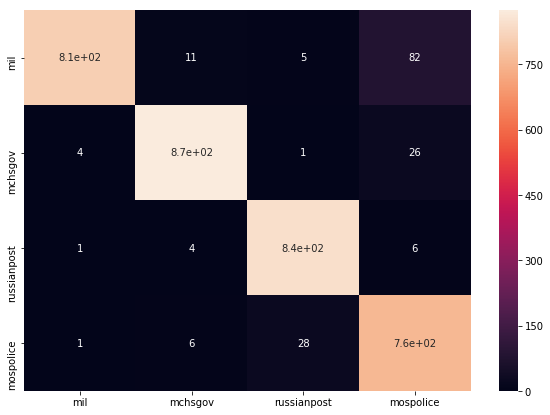

In [0]:
cm = confusion_matrix(targets, predictions)
plot_cm(cm)
print_metrics_from_cm(cm)

Качество чуть меньше, чем 0.95. Очень часто модель ошибочно приписывает лейбл 'mil' текстам с лейблом 'mospolice' (82 ошибки такого рода). Так же, как и ранее, редко совершаются ошибки в паре 'mchsgov' - 'russianpost', но много ошибок в парах 'russianpost' - 'mospolice' и 'mchsgov' - 'mil'.

## Конец
Выполните какие-то из предыдущих заданий. Для всех заданий, кроме задания 1 требуется вычислить метрику accuracy метода.

Подведите итоги и проведите сравнение всех использованных методов. Какой из них показался вам лучше и почему?

**NB!** Задание обязательное вне зависимости от того, сколько из предыдущих пунктов вы выполнили, и дополнительных баллов не дает.


Для получения полной оценки за NLP-часть достаточно набрать **20 баллов**.

Сравним по метрике accuracy (приводится наилучшее значение) все использованные в данной тетрадке модели:

1) rules-based approach: 0.7518591968269708

2) CountVectorizer + TfidfTransformer + MultinomialNB: 0.9658762290341237

3) CountVectorizer + TfidfTransformer + SGDClassifier: 0.9786003470213996

4) CountVectorizer + TfidfTransformer + LSA + SGDClassifier: 0.6576055523423945

5) CountVectorizer + TfidfTransformer + LSA + RandomForestClassifier: 0.7446500867553499

6) CountVectorizer + TfidfTransformer + LSA + LogisticRegression: 0.6827646038172354

7) CountVectorizer + TfidfTransformer + LSA + AdaBoostClassifier: 0.6561596298438404

8) CountVectorizer + TfidfTransformer + SGDClassifier (with lemmatization): 0.9783111625216888

9) CountVectorizer + TfidfTransformer + SGDClassifier (with lemmatization and n-grams (n <= 5)): 0.9788895315211105

10) Doc Embeddings (mean of all vectors): 0.9274146905725853

11) Doc Embeddings (tf-idf weighting): 0.9384037015615962

12) doc2vec (gensim, 5 epochs): 0.4068825910931174

13) fasttext: 0.9707923655292077

14) CNN: 0.9566223250433776

15) BiLSTM (1 epoch): 0.97165991902834

16) ULMFit: 0.9493927125506073

По метрике accuracy побеждает модель "CountVectorizer + TfidfTransformer + SGDClassifier (with lemmatization and n-grams (n <= 5))" с результатом 0.9788895315211105.

Хорошо себя показывают также fasttext, BiLSTM (>= 0.97).

Чуть хуже, но также в пределах "нормы": CountVectorizer + TfidfTransformer + MultinomialNB/, CNN, ULMFit, Doc Embeddings (tf-idf weighting/mean), ...

Все остальные варианты дают не очень хорошее качество либо по причине недообучения, либо по причине простоты самой модели (rule-based approach, например).

# Правила сдачи 

1. Домашняя работа должна быть выполнена в ipynb-тетрадке.
2. Сделанную тетрадку нужно отправить ассистенту (ссылка на контакты будет в вики).
3. Задание выполняется индивидуально.
4. Все вычисления должны быть снабжены пояснениями!
5. Дедлайн – 10 июня в 10.00.
